# 폐렴영상 진단 

In [272]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

In [273]:
#데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# x-ray 이미지 사이즈 변수
IMAGE_SIZE = [180,180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [274]:
#데이터 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [275]:
#val 데이터가 너무 없어서 데이터 사이즈 재조정
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [276]:
print(f'Normal image path \n{filenames[0]}')
print(f'Pneumonia image path \n{filenames[2000]}')

Normal image path 
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path 
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [277]:
#파일경로에 있는 노말 = 정상이미지, 뉴모니아 = 폐렴 이미지
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1078
Pneumonia images count in training set: 3107


In [278]:
#미니배치 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [279]:
#train data , val data 데이터 셋 개수확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {TRAIN_IMG_COUNT}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {VAL_IMG_COUNT}')

Training images count: 4185
Validating images count: 1047


In [280]:
#라벨 데이터 만들어주기 폐렴 양성 true 음성 false
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [281]:
#process함수에서 decode_img함수를 이용해 이미지의 타입을 float으로 바꾸고 사이즈조절
#get_label을 이용해서 라벨 값을 가져옴

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) #이미지를 unit8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) #float32타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) #이미지 사이즈를 IMAGE_SIZE로 수정
    return img

#이미지파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) #라벨검출
    img = tf.io.read_file(file_path)
    img = decode_img(img) #이미지 형식 수정
    return img, label

In [282]:
#학습 검증 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [283]:
#이미지와 라벨 확인
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy() )

Image shape: (180, 180, 3)
Label: False


In [284]:
#test데이터셋 만들고 갯수확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls =AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [285]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) #리소스 유휴상태 줄이기 
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화

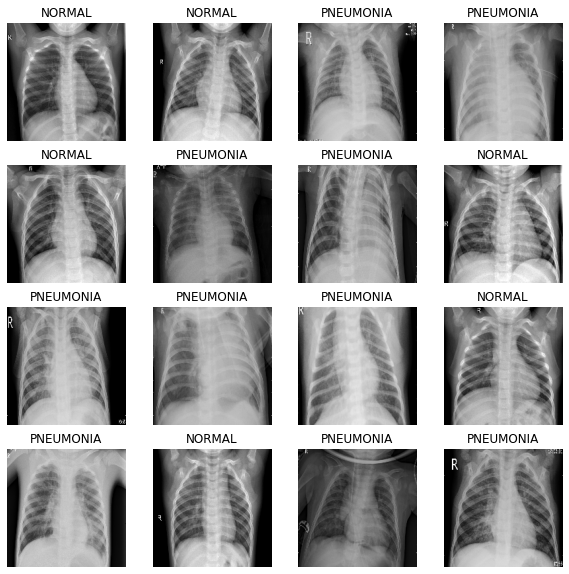

In [286]:
#train의 첫번째 배치 추출, 추출된 배치를 image와 label셋으로 나눔

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링

In [287]:
#CONVOLUTION BOLOCK 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same' ),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [288]:
#DENSE block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [289]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding= 'same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding= 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


# 데이터 imbalance 처리

데이터를 학습시에 데이터셋이 imbalance한 경우는 학습 효과가 좋지 않을 수 있음

이런 문제들을 해결하기 위해 Weight balancing 사용

트레이닝셋의 각 데이터에서 loss를 계산할때 특정 클래스의 데이터에 더 큰 loss값을 갖도록 가중치를 부여하는 법

아래 코드에서 weight_for_0 은 노말 이미지에 사용할 weight
weight_for_1은 폐렴이미지에 사용할 weight

In [290]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1:weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


# 모델 훈련

이미지 라벨은 이중분류이기에 binary cross entropy

In [291]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


In [292]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs =5,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    )

sample_batch = next(iter(train_ds))


Epoch 1/5
261/261 [==============================] - 62s 202ms/step - loss: 0.3819 - accuracy: 0.8118 - precision: 0.9498 - recall: 0.7880 - val_loss: 0.6914 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 52s 200ms/step - loss: 0.2176 - accuracy: 0.9162 - precision: 0.9791 - recall: 0.9066 - val_loss: 1.0995 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 53s 202ms/step - loss: 0.1893 - accuracy: 0.9296 - precision: 0.9769 - recall: 0.9271 - val_loss: 0.7338 - val_accuracy: 0.7452 - val_precision: 0.7440 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 53s 202ms/step - loss: 0.1744 - accuracy: 0.9389 - precision: 0.9814 - recall: 0.9355 - val_loss: 0.1040 - val_accuracy: 0.9654 - val_precision: 0.9647 - val_recall: 0.9897
Epoch 5/5
261/261 [==============================] - 53s 203ms/step - loss: 0.1520 - accuracy: 0

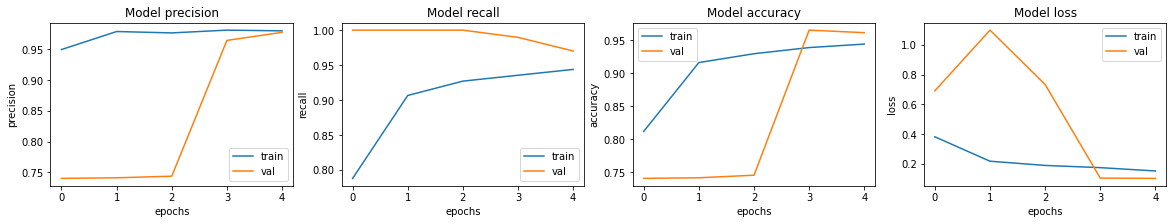

In [293]:
fig, ax = plt.subplots(1,4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [294]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 0.6601 - accuracy: 0.7548 - precision: 0.7207 - recall: 0.9923
Loss: 0.6600977778434753,
Accuracy: 0.754807710647583,
Precision: 0.7206704020500183,
Recall: 0.9923076629638672


In [184]:
import tensorflow
print(tensorflow.__version__)

2.6.0


# Step 실험환경 세팅

In [248]:
#배치사이즈는 32로 변경해봤고, 에폭은 여러 가지로 해보다가 다시 5로 변경했다.
BATCH_SIZE = 32
EPOCHS = 5

In [249]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

In [250]:
#데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# x-ray 이미지 사이즈 변수
IMAGE_SIZE = [180,180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


In [251]:
#데이터 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [252]:
#val 데이터가 너무 없어서 데이터 사이즈 재조정
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [253]:
#파일경로에 있는 노말 = 정상이미지, 뉴모니아 = 폐렴 이미지
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1077
Pneumonia images count in training set: 3108


In [254]:
#미니배치 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [255]:
#train data , val data 데이터 셋 개수확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {TRAIN_IMG_COUNT}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {VAL_IMG_COUNT}')

Training images count: 4185
Validating images count: 1047


In [256]:
#라벨 데이터 만들어주기 폐렴 양성 true 음성 false
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [257]:
#process함수에서 decode_img함수를 이용해 이미지의 타입을 float으로 바꾸고 사이즈조절
#get_label을 이용해서 라벨 값을 가져옴

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) #이미지를 unit8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) #float32타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) #이미지 사이즈를 IMAGE_SIZE로 수정
    return img

#이미지파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) #라벨검출
    img = tf.io.read_file(file_path)
    img = decode_img(img) #이미지 형식 수정
    return img, label

In [258]:
#학습 검증 데이터셋 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [259]:
#이미지와 라벨 확인
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy() )

Image shape: (180, 180, 3)
Label: True


In [260]:
#test데이터셋 만들고 갯수확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls =AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [261]:
#좌우반전 이미지를 추가해서 만들어보기
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment, 
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) #리소스 유휴상태 줄이기 
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

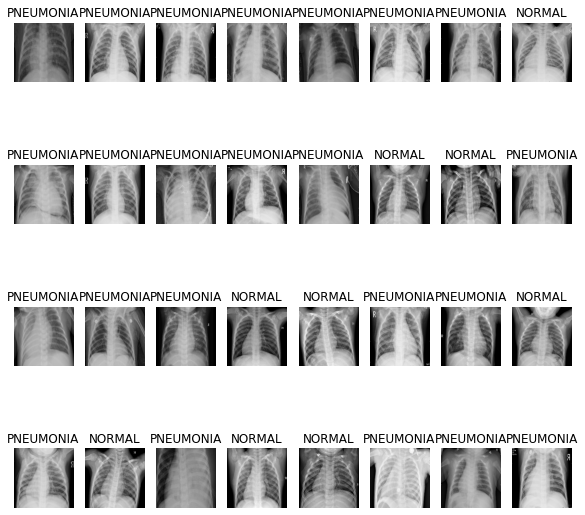

In [262]:
#train의 첫번째 배치 추출, 추출된 배치를 image와 label셋으로 나눔

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 심장음영위치를 통해서 영상 좌우반전이 
# 성공적으로 됐다는것을 확인

# ResNet-18 구현

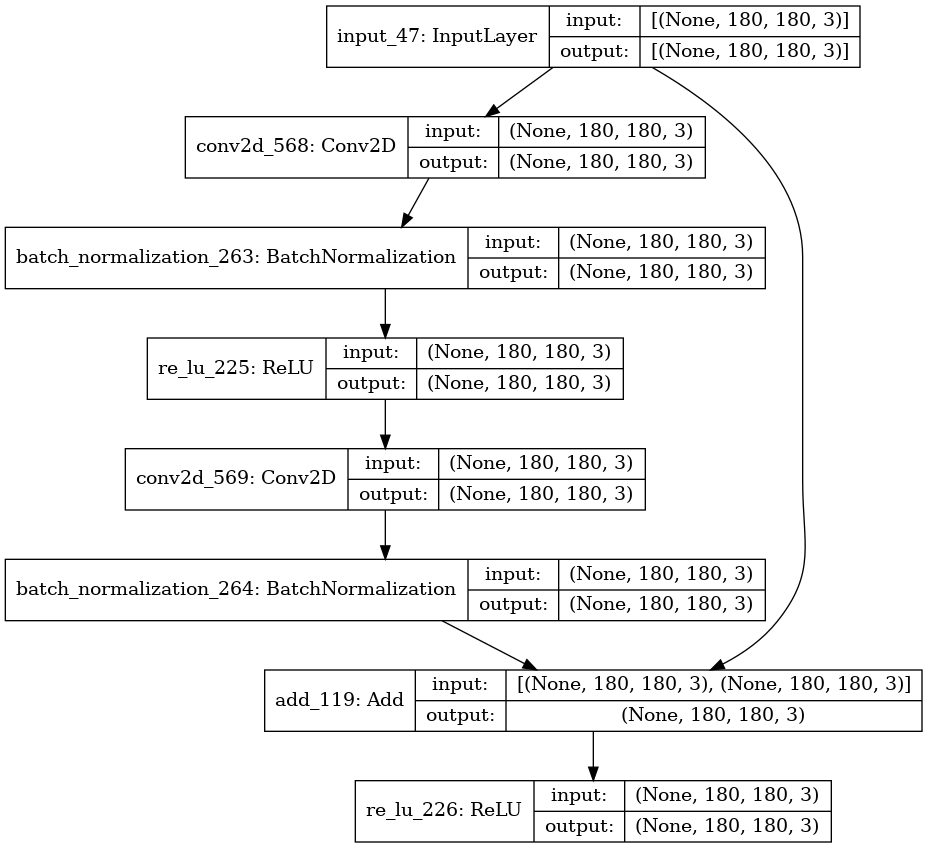

In [263]:
from tensorflow.keras import layers, Model
#residual block 만들기
def residual_block(x, filters_in, filters_out, kernel_size):
    shortcut = x
    x = layers.Conv2D(filters_in, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters_in, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    shortcut_channel = x.shape.as_list()[-1] #skip connection 구현
    
    if shortcut.shape[-1] != filters_out:
        shortcut = layers.Conv2D(filters_out, kernel_size=(1,1), strides=(1,1), padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

input_layer = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = residual_block(input_layer, filters_in=3, filters_out=3, kernel_size=(3, 3))
model = Model(inputs=input_layer, outputs=x)

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_570 (Conv2D)             (None, 180, 180, 64) 9472        input_48[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 90, 90, 64)   0           conv2d_570[0][0]                 
__________________________________________________________________________________________________
conv2d_571 (Conv2D)             (None, 90, 90, 64)   36928       max_pooling2d_37[0][0]           
___________________________________________________________________________________________

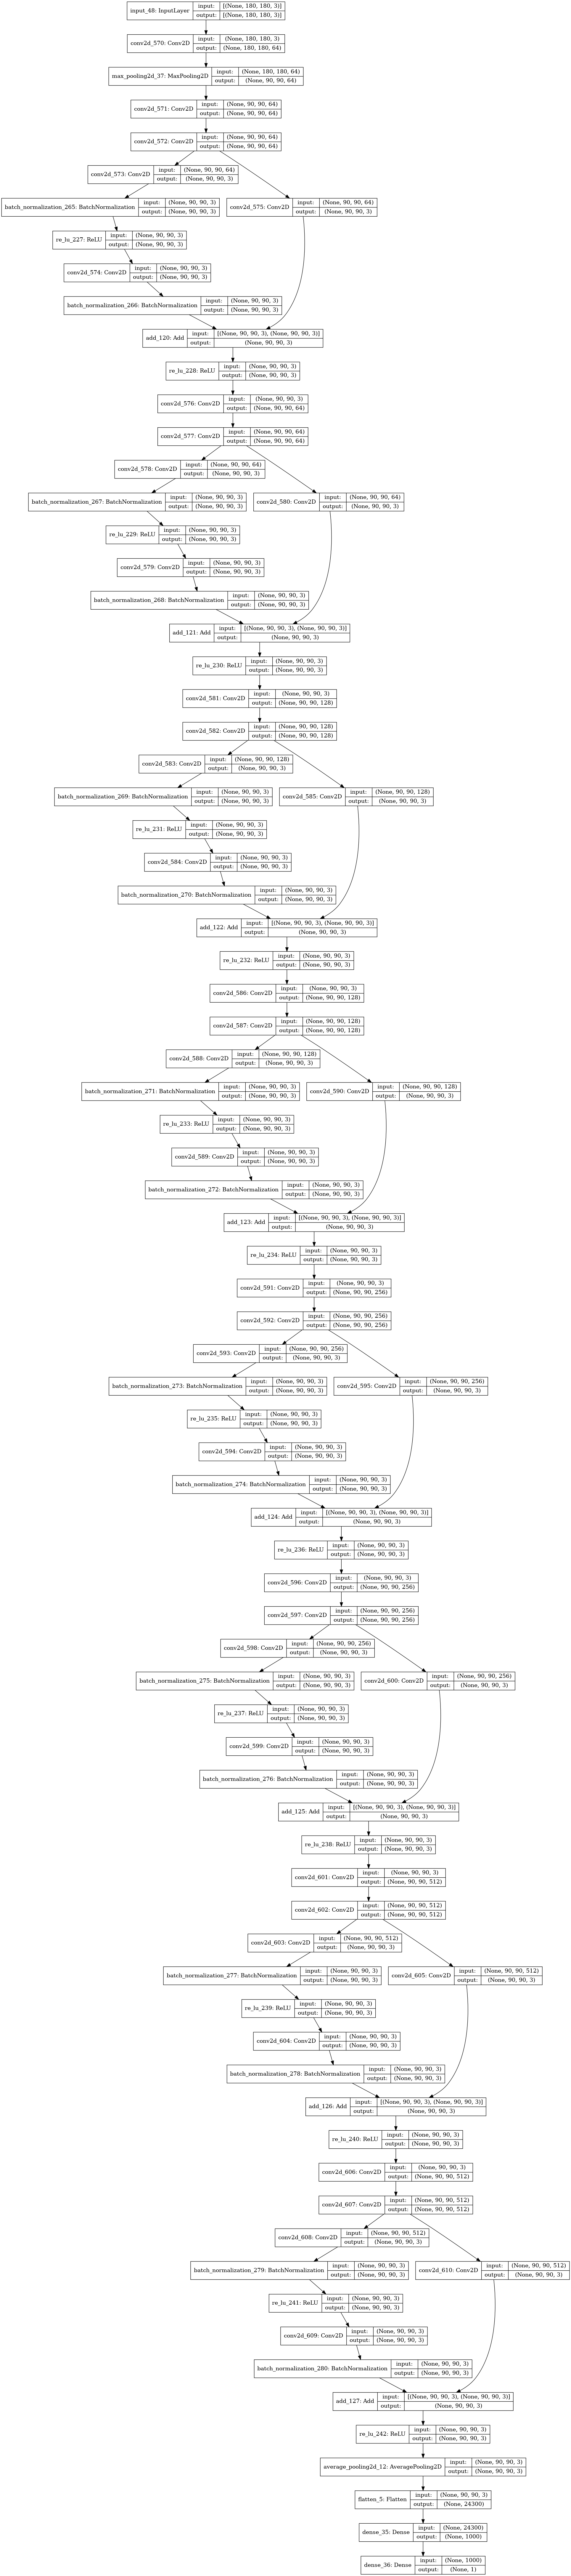

In [271]:
#resnet층 만들기
from tensorflow.keras.layers import Input

def ResNet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), classes=2):
    x_input = Input(shape=input_shape)
    x = x_input
    
    x = layers.Conv2D(64, kernel_size=(7,7) , strides=(1,1), padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3,filters_out=3, kernel_size=(3,3))
    
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))
    
    x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))
    x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))

    x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))
    x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = residual_block(x, filters_in=3, filters_out=3, kernel_size=(3,3))
    
    x = layers.AveragePooling2D(pool_size=(7,7), strides=(1,1), padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1000, activation='relu')(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model2 = Model(inputs=x_input, outputs=x, name='ResNet18')
    return model2

model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [265]:
#데이터 imblance처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1:weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [266]:
with tf.device('/GPU:0'):
    model = ResNet18()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [268]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs =1,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    )

# 훈련 데이터셋의 첫 번째 배치를 가져와서 형태 확인

sample_batch = next(iter(train_ds))
print("Sample Batch Shape:", sample_batch[0].shape)  # 입력 데이터 형태
print("Sample Batch Labels Shape:", sample_batch[1].shape)  # 타깃 데이터 형태


130/130 [==============================] - 203s 2s/step - loss: 0.6925 - accuracy: 0.5637 - precision: 0.7349 - recall: 0.6463 - val_loss: 0.6930 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Sample Batch Shape: (32, 180, 180, 3)
Sample Batch Labels Shape: (32,)


위 코드는 차원 간 계산 오류가 계속 발생해서 확인을 위해 집어넣었다.
입력 데이터는 4차원이고 검증데이터는 2차원인걸확인하고
ResNet에 flatten 레이어를 추가했다.

In [269]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 13s 615ms/step - loss: 0.6931 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6930925250053406,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 결론

## 평가

1. CNN기반 모델이 잘 구현되었는가? 
- 네, 시각화된 자료를 통해 모델이 잘 구현되었다는 것을 확인했습니다.

2. 데이터준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었는가?
- 노드를 따라가며 필요한 부분들은 수정해가며 실험해보았습니다.

3. ResNet모델을 구현하였는가?
- 네,시각화 자료를 통해 ResNet의 모식도를 도출하는것으로 마무리지었습니다.

## 회고
의료영상데이터엔지니어가 되고 싶어서 아이펠에 들어왔던 만큼
이전 퀘스트들보다 더 몰입해서 할 수 있었다.
기본 개념들을 읽으면서 예전 생각도 많이났다.

모델 구현하는 부분에서 정말 솔직하게 이렇게 구성을 하는데 모델이 제대로 돌아갈까 라는
생각이 많았다. 물론 다 만들고나서도 정확도는 내 기대에 많이 미치지 못했고..
주말에 시간을 내서 코드를 뜯어볼 생각이다.



### REF.

[[딥러닝] ResNet - Residual Block 쉽게이해하기! (Pytorch 구현)](https://coding-yoon.tistory.com/141)

[개발자j의일상](https://mypark.tistory.com/entry/Tensorflow-2Keras-Week-4-Implementing-ResNet)

[[CV] ResNet-18로 특정 Image의 feature 추출하기](https://daeun-computer-uneasy.tistory.com/85)
